### Creating DataFrame

In [3]:
#Import necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium

#Read in the downloaded data
#data = pd.read_csv(r"D:\WorkSpace\Bike Mapping\201812-citibike-tripdata\201812-citibike-tripdata.csv")
#Check top 5 rows of the data
#data.head()

In [ ]:
#Check data information number of rows, columns
data.info()

In [4]:
#Convert the start time and stop time columns to timestamp
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

#Create new column from starttime column showing the day of the week
data['start day']=data['starttime'].dt.day.astype('category') 
data['weekday']=data['starttime'].dt.weekday.astype('category')

#Use mapping to rename the column values of weekday
data['weekday'] = data['weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
data.head()

tripduration               starttime                stoptime  \
0           689 2018-12-01 00:00:04.302 2018-12-01 00:11:33.846   
1           204 2018-12-01 00:00:05.533 2018-12-01 00:03:30.523   
2           316 2018-12-01 00:00:10.233 2018-12-01 00:05:27.203   
3           726 2018-12-01 00:00:21.957 2018-12-01 00:12:28.183   
4           397 2018-12-01 00:00:29.632 2018-12-01 00:07:07.446   

   start station id          start station name  start station latitude  \
0            3359.0       E 68 St & Madison Ave               40.769157   
1            3504.0    E 123 St & Lexington Ave               40.802926   
2             270.0     Adelphi St & Myrtle Ave               40.693083   
3             495.0            W 47 St & 10 Ave               40.762699   
4             473.0  Rivington St & Chrystie St               40.721101   

   start station longitude  end station id            end station name  \
0               -73.967035           164.0             E 47 St & 2 Ave   
1               -73.937900          3490.0            E 116 St & 2 Ave   
2               -73.971789           243.0     Fulton St & Rockwell Pl   
3               -73.993012          3660.0             W 16 St & 8 Ave   
4               -73.991925          3467.0  W Broadway & Spring Street   

   end station latitude  end station longitude  bikeid    usertype  \
0             40.753231             -73.970325   35033  Subscriber   
1             40.796879             -73.937261   20501  Subscriber   
2             40.688226             -73.979382   18386  Subscriber   
3             40.741022             -74.001385   27616  Subscriber   
4             40.724947             -74.001659   35096  Subscriber   

   birth year  gender start day   weekday  
0        1989       1         1  Saturday  
1        1966       1         1  Saturday  
2        1984       1         1  Saturday  
3        1983       1         1  Saturday  
4        1976       1         1  Saturday

## Using Seaborn and Matplotlib for exploring the data

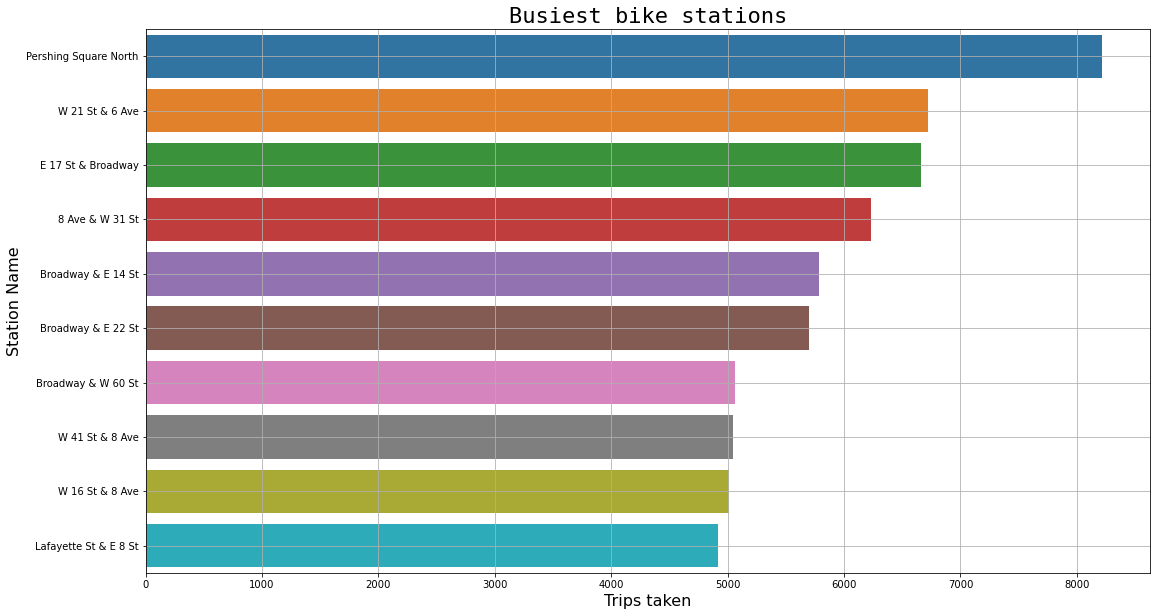

In [5]:
#Use seaborn and matplotlib to plot the top 10 busiest stations

startstation = data['start station name'].value_counts()[:10]
plt.figure(figsize=(18,10))
sns.barplot( x=startstation.values , y=list(startstation.index), 
 orient="h" )

#Add plot title, label axes and grid
plt.title('Busiest bike stations', size=22, family='monospace')
plt.ylabel('Station Name', fontsize=16)
plt.xlabel('Trips taken', fontsize=16)
plt.grid()
plt.tight_layout

#Save the output to file
plt.savefig("busiest_stations.png", facecolor='white', dpi=300)

plt.show()

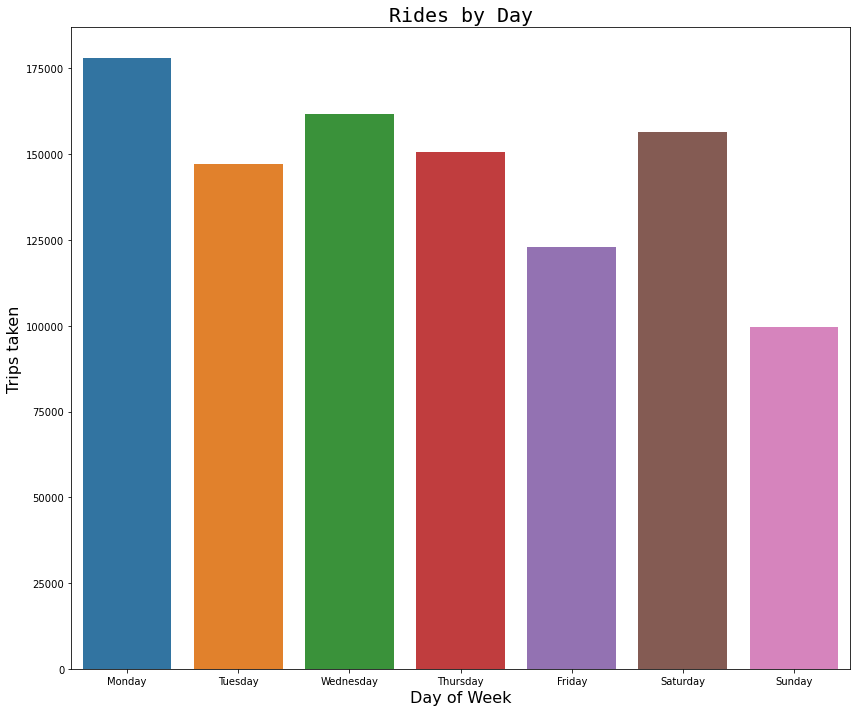

In [6]:
#Group by day of the week and create a subset of the data
group = data.groupby(['weekday'], as_index=False).agg(
    count_col=pd.NamedAgg(column="weekday", aggfunc="count")
)
group.rename(columns={'weekday': 'Day of Week', 
                    'count_col':'Trips taken'}, inplace=True)
group

#Use seaborn and matplotlib to plot graph showing busiest day of the week
plt.figure(figsize=(12,10))
ax = sns.barplot(x = 'Day of Week',
            y = 'Trips taken',
            data = group)
#Add plot title, label axes
plt.title('Rides by Day', size=20, family='monospace')
plt.ylabel('Trips taken', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)
plt.tight_layout()

#Save the output to file
plt.savefig("rides_by_day.png", facecolor='white',dpi=300)

plt.show()

In [7]:
#Using the aggregate with groupby to group and 
#count the number of occurences in each group and assign to a new dataframe
df_grouped = data.groupby(['start station id', 'start station name', 'start station latitude',
       'start station longitude'], as_index=False).agg(
    count_col=pd.NamedAgg(column="start station id", aggfunc="count")
)

print(len(df_grouped))

# Rename our columns
df_grouped.rename(columns={'start station id': 'Station ID', 
                    'start station name': 'Station Name', 
                    'start station latitude': 'Lat', 
                    'start station longitude': 'Lon', 
                    'count_col':'Number of Trips'}, inplace=True)

# Saving the dataframe to csv file
outpath = r'./2018Dec.csv'
df_grouped.to_csv(outpath, index=False)

762


In [8]:
#Print statement to check for duplicate values
print(f"There are {df_grouped.duplicated(subset='Station ID').sum()},"
      f" duplicate values from a total of {len(df_grouped)},"
      f" values in the 2018 cleaned dataset.")

There are 0, duplicate values from a total of 762, values in the 2018 cleaned dataset.


### Converting DataFrame to GeoDataFrame

Before we go ahead and convert the dataframe, we'll repeat the steps above for our 2019 and 2020 data.

In [7]:
#Read and process our cleaned 2018,2019 and 2020 datasets for mapping

#2018

data2018 = pd.read_csv(r'../data/2018Dec.csv')

#Convert DataFrame to GeoDataFrame
gdf_2018 = gpd.GeoDataFrame(
    data2018, geometry=gpd.points_from_xy(data2018.Lon, data2018.Lat))

#Assign crs to the geodataframe
gdf_2018 = gdf_2018.set_crs('epsg:4326')
# Let's make a backup copy of our data
gdf_merc18 = gdf_2018.copy()
#We will use the backup in our subsequent analysis
gdf_merc18 = gdf_merc18.to_crs(epsg=3857)

#sorting 2018 data frame by Trips
gdf_merc18.sort_values("Number of Trips", axis = 0, ascending = False,
                 inplace = True, na_position ='last')

#Assign the sorted dataframe top 100 rows to a dataframe to be used in our maps
gdf_2018_n100 = gdf_merc18.iloc[:100]

print('Finished with 2018')

#2019

data2019 = pd.read_csv(r'../data/2019Dec.csv')

#Convert DataFrame to GeoDataFrame
gdf_2019 = gpd.GeoDataFrame(
    data2019, geometry=gpd.points_from_xy(data2019.Lon, data2019.Lat))

#Assign crs to the geodataframe
gdf_2019 = gdf_2019.set_crs('epsg:4326')
# Let's make a backup copy of our data
gdf_merc19 = gdf_2019.copy()
#We will use the backup in our subsequent analysis
gdf_merc19 = gdf_merc19.to_crs(epsg=3857)

#sorting 2019 data frame by Trips
gdf_merc19.sort_values("Number of Trips", axis = 0, ascending = False,
                 inplace = True, na_position ='last')

#Assign the sorted dataframe top 100 rows to a dataframe to be used in our maps
gdf_2019_n100 = gdf_merc19.iloc[:100]

print('Finished with 2019')

#2020

data2020 = pd.read_csv(r'../data/2020Dec.csv')

#Convert DataFrame to GeoDataFrame
gdf_2020 = gpd.GeoDataFrame(
    data2020, geometry=gpd.points_from_xy(data2020.Lon, data2020.Lat))

#Assign crs to the geodataframe
gdf_2020 = gdf_2020.set_crs('epsg:4326')
# Let's make a backup copy of our data
gdf_merc20 = gdf_2020.copy()
#We will use the backup in our subsequent analysis
gdf_merc20 = gdf_merc20.to_crs(epsg=3857)

#sorting 2020 data frame by Trips
gdf_merc20.sort_values("Number of Trips", axis = 0, ascending = False,
                 inplace = True, na_position ='last')

#Assign the sorted dataframe top 100 rows to a dataframe to be used in our maps
gdf_2020_n100 = gdf_merc20.iloc[:100]

print('Finished with 2021')

#2021

data2021 = pd.read_csv(r'../data/2021Dec_revised.csv')

#Convert DataFrame to GeoDataFrame
gdf_2021 = gpd.GeoDataFrame(data2021
    , geometry=gpd.points_from_xy(data2021.Lon, data2021.Lat))
gdf_2021
#Assign crs to the geodataframe
gdf_2021 = gdf_2021.set_crs('epsg:4326')
# Let's make a backup copy of our data
gdf_merc21 = gdf_2021.copy()
#We will use the backup in our subsequent analysis
gdf_merc21 = gdf_merc21.to_crs(epsg=3857)

#sorting 2021 data frame by Trips
gdf_merc21.sort_values("Number of Trips", axis = 0, ascending = False,
                 inplace = True, na_position ='last')

#Assign the sorted dataframe top 100 rows to a dataframe to be used in our maps
gdf_2021_n100 = gdf_merc21.iloc[:100]

print('Finished with 2021')

Finished with 2018
Finished with 2019
Finished with 2021
Finished with 2021


### Static Map

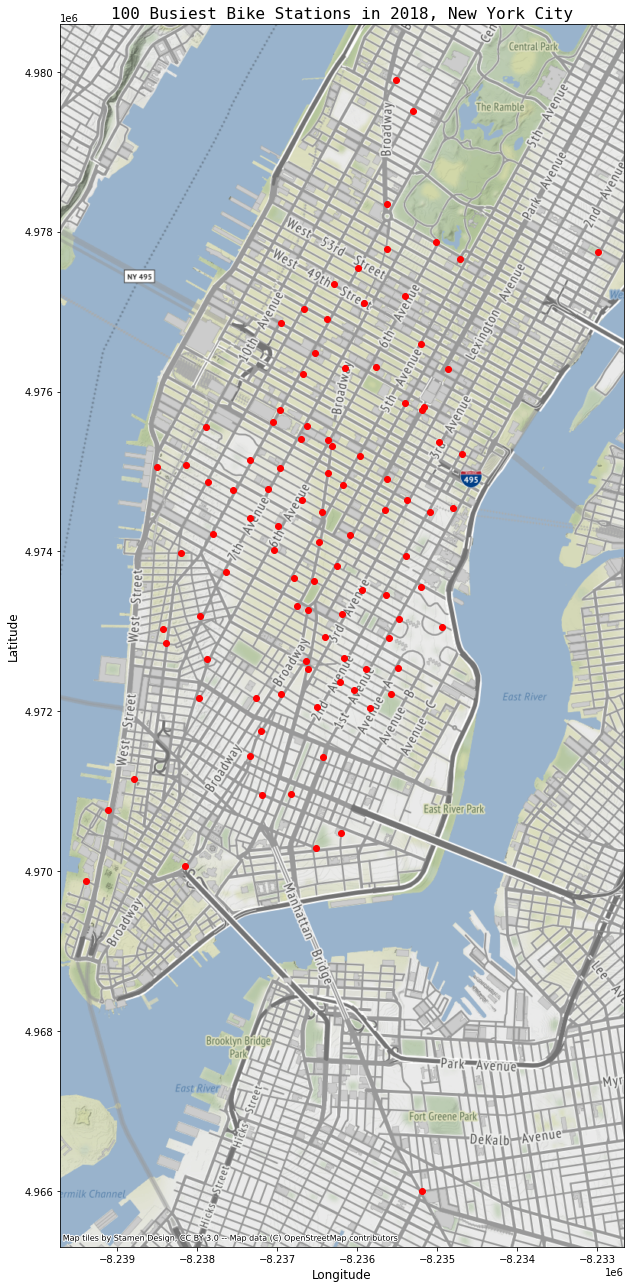

In [11]:
#Import matplotlib package for our plotting and contextly for our basemaps
import matplotlib.pyplot as plt
import contextily as ctx

# Create subplot for 2018 data
fig, ax = plt.subplots(figsize=(15,18))

#Plot the static map
gdf_2018_n100.plot(ax=ax,c="red") 

# Set title and label axes
plt.title("100 Busiest Bike Stations in 2018, New York City", 
          fontsize=16,family="Monospace")
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()

#Add basemap from contextily
ctx.add_basemap(ax)

#Save the figure as png file
#plt.savefig("2018_static_map", facecolor="white", dpi=196)

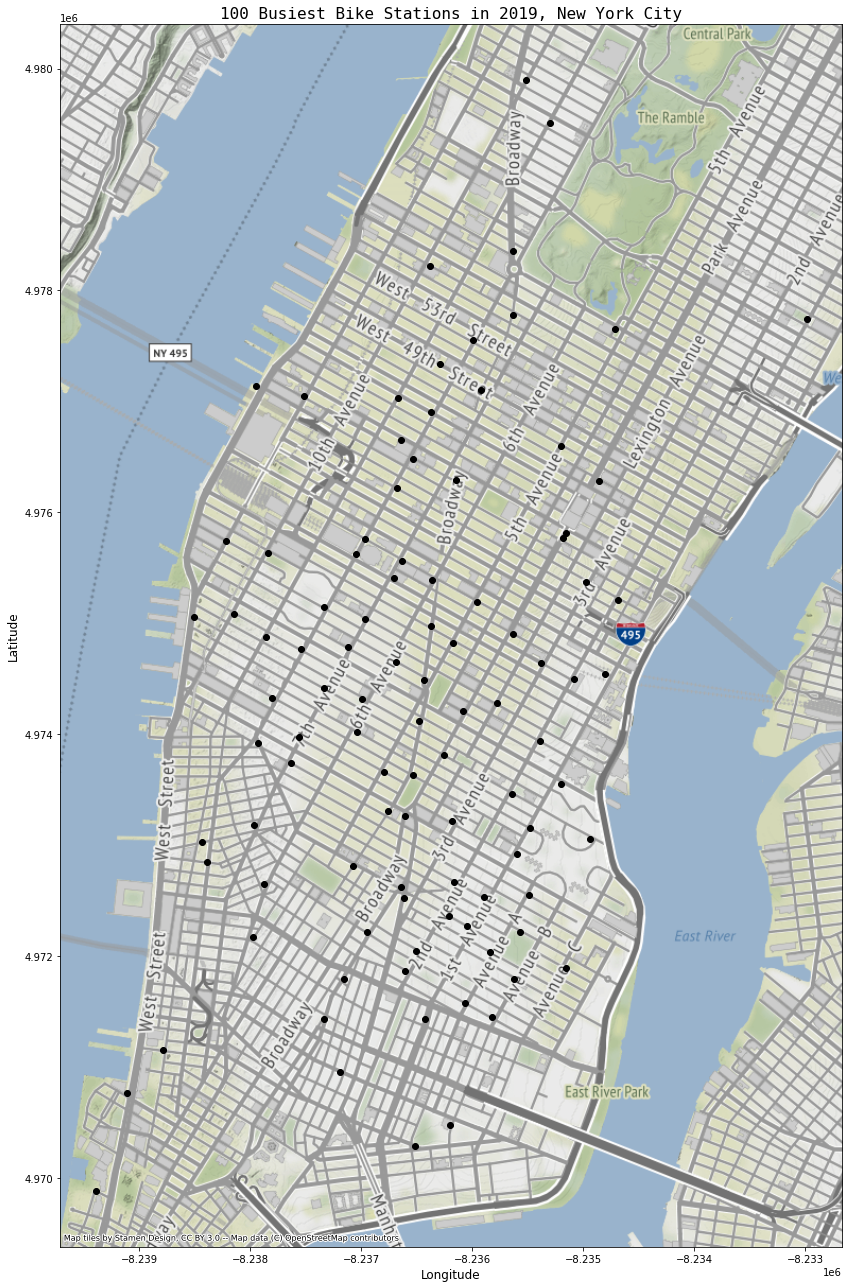

<Figure size 432x288 with 0 Axes>

In [17]:
# Create the next subplot for 2019
fig, ax1 = plt.subplots(figsize=(15,18))

#Plot the static map
gdf_2019_n100.plot(ax=ax1,c="black") 
                   
# Set title and label axes
plt.title("100 Busiest Bike Stations in 2019, New York City", 
          fontsize=16,family="Monospace")
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()

#Add basemap from contextily
ctx.add_basemap(ax1)
plt.show()

#Save the figure as png file
#plt.savefig("2019_static_map.png", facecolor='white',dpi=196)

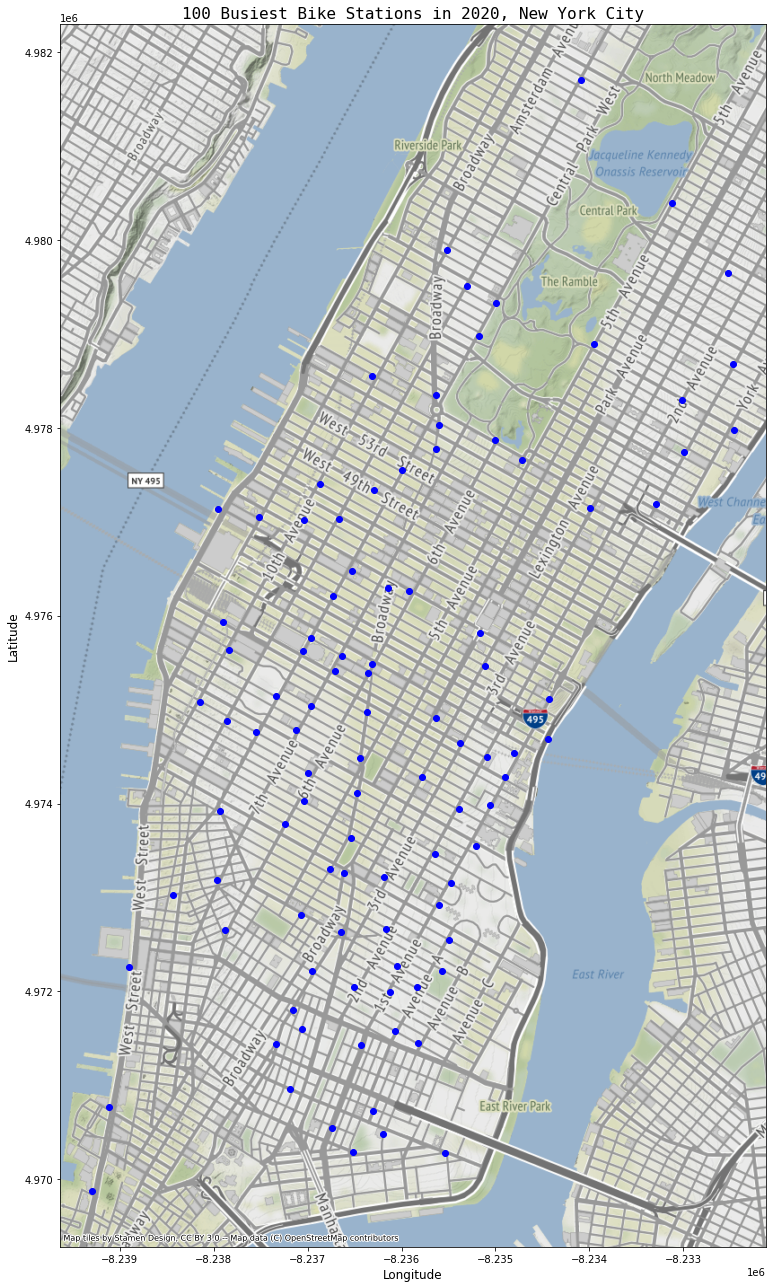

<Figure size 432x288 with 0 Axes>

In [16]:
# Create the next subplot for 2020
fig, ax2 = plt.subplots(figsize=(15,18))

#Plot the static map
gdf_2020_n100.plot(ax=ax2,c="blue") 
                   
# Set title and label axes
plt.title("100 Busiest Bike Stations in 2020, New York City", 
          fontsize=16,family="Monospace")
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()

#Add basemap from contextily
ctx.add_basemap(ax2)
plt.show()

#Save the figure as png file
#plt.savefig("2020_static_map.png", facecolor='white',dpi=196)

### Interactive Map

In [21]:
#Import folium package for interactive mapping
import folium

#Create Map instance
m=folium.Map(location=[40.751873, -73.977706], zoom_start=13, attr='MyData')

#Add another basemap layer
#folium.TileLayer('OpenStreetMap', show =True).add_to(m)

#Add Title to Interactive map
loc = 'Top 100, Busiest Bike Stations in New York City by Years'
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(loc) 
m.get_root().html.add_child(folium.Element(title_html))

#Create feature groups
f1=folium.FeatureGroup("Busiest Stations in 2018")
f2=folium.FeatureGroup("Busiest Stations in 2019", show =False)
f3=folium.FeatureGroup("Busiest Stations in 2020", show = False)
f4=folium.FeatureGroup("Busiest Stations in 2020", show = False)

#Add the dataframes to our feature groups
gd2018 = folium.GeoJson(gdf_2018_n100,marker=folium.Marker(
                        icon=folium.Icon(color='red')),
                        tooltip=folium.GeoJsonTooltip(
                        fields=["Station Name","Number of Trips"]),
                       ).add_to(f1)
gd2019 = folium.GeoJson(gdf_2019_n100,marker=folium.Marker(
                        icon=folium.Icon(color='green')),
                        tooltip=folium.GeoJsonTooltip(
                        fields=["Station Name","Number of Trips"]),).add_to(f2)
gd2020 = folium.GeoJson(gdf_2020_n100,marker=folium.Marker(
                        icon=folium.Icon(color='darkblue')),
                        tooltip=folium.GeoJsonTooltip(
                        fields=["Station Name","Number of Trips"]),).add_to(f3)

#Add feature groups to Map instance
f1.add_to(m)
f2.add_to(m)
f3.add_to(m)

#Add layer Control
folium.LayerControl().add_to(m)  # use folium to add layer control
m

In [30]:
outfp = r"./interactive_map.html"
m.save(outfp)